<a href="https://colab.research.google.com/github/tonyscan6003/etivities/blob/main/Example_cross_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Template matching with Cross Correlation.

In this example we will perform Template matching with an image and template using cross correlation. We will also perform normalised cross correlation and verify that this is the better performing algorithm as it avoids high correlation in regions of high image intenstiy by including normalisation.




**Housekeeping:** Import Libraries, read image

In [ ]:
import numpy as np
import urllib.request
import numpy as np
import cv2
from scipy import signal
from matplotlib import pyplot as plt

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
	# Crop a region of the image to act as template
	template = temp_image[150:210,230:320]
	return temp_image,template


def norm_img(act_map):
   offset = np.min(act_map)
   act_map=act_map-offset
   max_val = np.max(act_map)
   act_map = 255.0*(act_map)/max_val
   return act_map

(-0.5, 89.5, 59.5, -0.5)

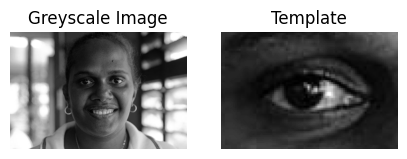

In [ ]:

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/More_of_my_Favourite_Faces_%282%29_%28Imagicity_648%29.jpg/640px-More_of_my_Favourite_Faces_%282%29_%28Imagicity_648%29.jpg"
image,template = url_to_image(image_url)

# Display Image and template region
f, axarr = plt.subplots(1,2,figsize=(5,8))
axarr[0].imshow(image,'gray')
axarr[0].title.set_text('Greyscale Image')
axarr[0].axis('off')
axarr[1].imshow(template,'gray')
axarr[1].title.set_text('Template')
axarr[1].axis('off')

# Part 1: Correlation Based Matching

Correlation between the input image and template can be easily found using the [signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) method in SciPy. The method implements the basic correlation equation:

 $R(m,n)=\sum\limits_x \sum\limits_y (I(x,y))(T(x-m,y-n))$

In order to improve the result of correlation the mean of the template is removed (in the code below) prior to correlation.

In [ ]:
# Convert Image and Template to Float 32 to allow subtraction of mean and correlation
template.astype(np.float32)
image.astype(np.float32)
# Find and subtract mean of template
mean_template = template.mean()
template_adj = template-mean_template
# Apply Correlation
corr_img = signal.correlate2d(image, template_adj, mode='same',boundary='symm')
corr_img = norm_img(corr_img)

#plt.imshow(corr_img,'jet')

We display a plot of the Image, template and Correlation as a heat map in the code cell below.
While the correlation method can find the exact location of the template in the image, it is noted that other maxima are found. In particular correlation is found in regions of high image intensity. As we will see in Part two by using Normalised Cross Correlation, these maxima can be greatly reduced.

(-0.5, 639.5, 424.5, -0.5)

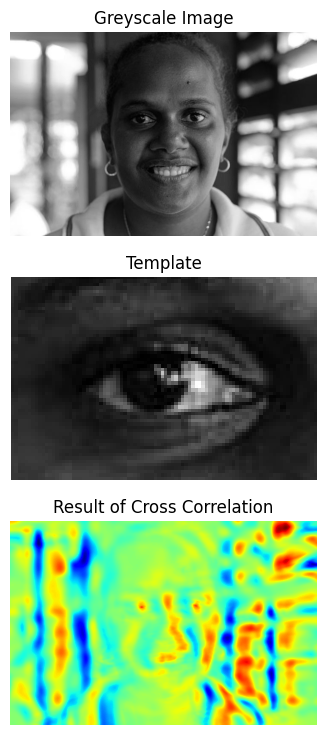

In [ ]:
# Display PLot of Image, template and Correlation as heat map
f, axarr = plt.subplots(3,1,figsize=(12,9))

axarr[0].imshow(image,'gray')
axarr[0].title.set_text('Greyscale Image')
axarr[0].axis('off')
axarr[1].imshow(template,'gray')
axarr[1].title.set_text('Template')
axarr[1].axis('off')
axarr[2].imshow(corr_img,'jet')
axarr[2].title.set_text('Result of Cross Correlation')
axarr[2].axis('off')

Additionally we can find Coordinates of Maximum and Mark on Original Image. We can do this using the peak_local_max method as detailed [here](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html).

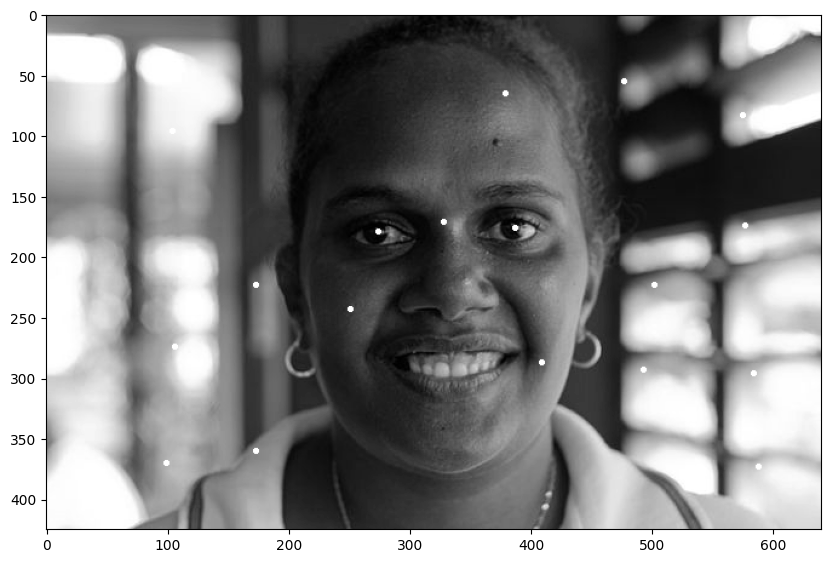

In [ ]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage import data, img_as_float



# Comparison between image_max and vals_greater_thresh to find the coordinates of local maxima
coordinates = peak_local_max(corr_img, min_distance=50,threshold_abs=150)

# plot coordinates on original image
for xy_pos in coordinates:
   cv2.circle(image, (xy_pos[1],xy_pos[0]), 1, (255,0,0),thickness=2)

plt.figure(figsize=(10,10))
plt.imshow(image,'gray')

# Part 2: Normalised Cross Correlation

In normalised Cross Correlation (equation below), we normalise the correlation result in each template position. This is more computationally expensive than standard correlation, but eliminates the effect of regions of high image intensity appearing to have high correlation with the template. Note that the terms in the denominator are calculated over the template window.

>$NCC(m,n)=\frac{  \sum\limits_x \sum\limits_y (I(x,y)-\hat{I}_{m,n})(T(x-m,y-n)-\hat{T})}{\sqrt{\sum\limits_x \sum\limits_y (I(x,y)-\hat{I}_{m,n})^2}\sqrt{\sum\limits_x \sum\limits_y (T(x-n,y-m)-\hat{T})^2} }$

There is no scipy function to perform Normalised Cross Correlation so it is necessary to create one. This can be easily done by iterating over the x,y coordinates of the image and performing the normalised correlation at each position.

Algorithm:
> Calculate template Mean $\hat{T}$ and Mean adjusted template $T(x-m,y-n)-\hat{T}$ and standard deviation term for template $\sqrt{\sum\limits_x \sum\limits_y (T(x-n,y-m)-\hat{T})^2}$ (both terms will be same in every template position)

> Iterate Template over image
*   Calculate Local Mean $\hat{I}_{m,n}$ of Image under template
*   Calculate mean adjusted Image  $I(x,y)-\hat{I}_{m,n}$
*   Get numerator of equation (cross correlation term) $\sum\limits_x \sum\limits_y (I(x,y)-\hat{I}_{m,n})(T(x-m,y-n)-\hat{T})$. This operation is an elementwise multiplication and sum
* Calculate standard deviation term for the area of the image under the template $\sqrt{\sum\limits_x \sum\limits_y (I(x,y)-\hat{I}_{m,n})^2}$
* Determine $NCC(m,n)$ using calculated terms and store




In [ ]:
# Perform normalised cross correlation by setting up own loop to do this. Operate over valid pixels only
y_max,x_max =np.shape(image) # Iterate over image
t_y,t_x = np.shape(template) # Step by size of templete

# Calculate template mean, mean adjusted template and std term (always same)
template_mean= np.mean(template)
template_adj = template-template_mean
template_std = np.sqrt(np.sum(template_adj**2))

# Setup array to store correlation values
norm_corr_img = np.zeros((y_max-t_y,x_max-t_x))

cntr=0
for y in range(y_max-t_y):
    for x in range(x_max-t_x):
       # Calculate local mean
       local_mean = np.mean(image[y:y+t_y,x:x+t_x])

       # Calculate local mean adjusted image
       image_adj = image-local_mean
       # Apply cross correlation
       corr_mn = np.sum(np.multiply(image_adj[y:y+t_y,x:x+t_x],template_adj))

       # Std term for Image (assume is over window)
       image_std = np.sqrt(np.sum(image_adj[y:y+t_y,x:x+t_x]**2))

       # Calculate NCC(m,n)
       corr_mn = corr_mn/(image_std*template_std)

       # Store Output
       norm_corr_img[y,x] =corr_mn


#plt.imshow(norm_corr_img,'jet')

(-0.5, 549.5, 364.5, -0.5)

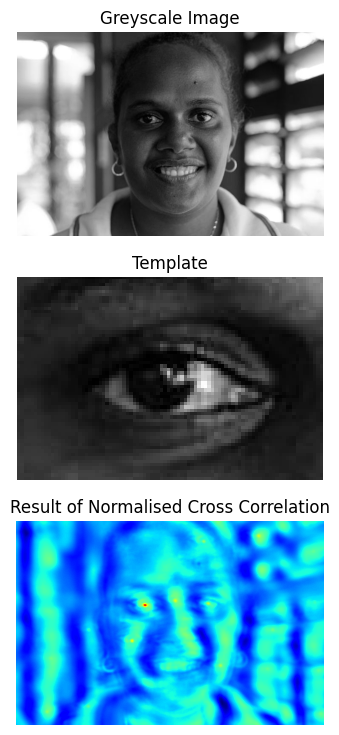

In [ ]:
f, axarr = plt.subplots(3,1,figsize=(12,9))
image,template = url_to_image(image_url)
# Display Image and template region
axarr[0].imshow(image,'gray')
axarr[0].title.set_text('Greyscale Image')
axarr[0].axis('off')
axarr[1].imshow(template,'gray')
axarr[1].title.set_text('Template')
axarr[1].axis('off')
axarr[2].imshow(norm_corr_img,'jet')
axarr[2].title.set_text('Result of Normalised Cross Correlation')
axarr[2].axis('off')